### CNN Model

Convolutional Neural Network (CNN) models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

1D Convolutional Neural Networks work well for:
- Analysis of a time series of sensor data.
- Analysis of signal data over a fixed-length period, for example, an audio recording.
- Natural Language Processing (NLP), although Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells are more promising than CNN as they take into account the proximity of words to create trainable patterns.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [19]:
apple_close_price = get_apple_close_price()

In [20]:
short_series = get_range(apple_close_price, '2003-01-01')

In [21]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [22]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [23]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [24]:
boxcox_series, lmbda = boxcox(train.values)

In [25]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

In [28]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [29]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [30]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LeakyReLU
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

In [31]:
def build_CNN(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(Conv1D(64, 
                     kernel_size=4, 
                     activation='relu', 
                     input_shape=(look_back, n_features)))
    model.add(Flatten())
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [32]:
model = build_CNN(look_back, n_features, n_outputs)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2, 64)             320       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 965
Trainable params: 965
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/100
9439/9439 [==============================] - 12s 1ms/step - loss: 0.0026
Epoch 2/100
9439/9439 [==============================] - 1s 80us/step - loss: 8.1260e-04
Epoch 3/100
9439/9439 [==============================] - 1s 78us/step - loss: 4.0585e-04
Epoch 4/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.4348e-04
Epoch 5/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.0196e-04
Epoch 6/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.0281e-04
Epoch 7/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.2310e-04
Epoch 8/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.5057e-04
Epoch 9/100
9439/9439 [==============================] - 1s 80us/step - loss: 2.7269e-04
Epoch 10/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.8626e-04
Epoch 11/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.8787e-04
Epoch 12/100
9439/9439 

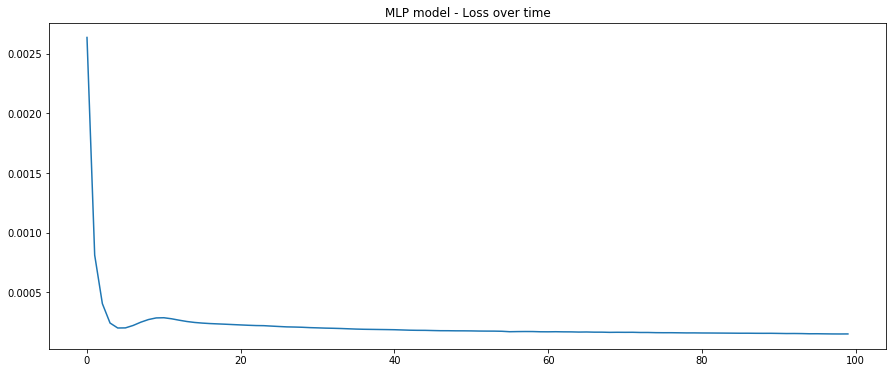

In [35]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [36]:
model.save_weights('css-model_weights.h5')

In [37]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation(model, 
                                         scaled_train, scaled_test[:252],
                                         size=size,
                                         look_back=look_back, 
                                         n_outputs=n_outputs)

In [38]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [39]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

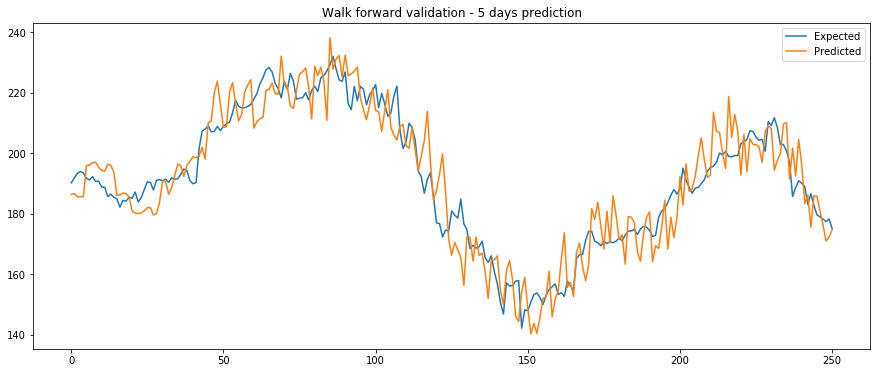

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

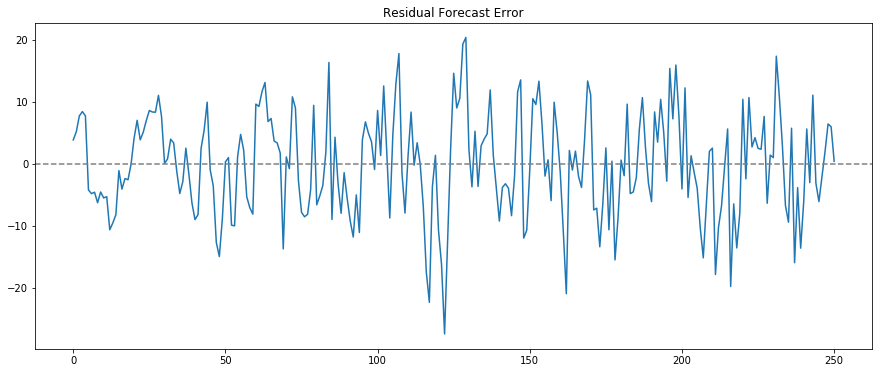

In [41]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [42]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='CNN', 
                          total_days=size, steps=n_outputs)

CNN[252 days, 5 days forecast]:

Forecast Bias: -0.222
MAE: 6.720
MSE: 68.515
RMSE: 8.277
MAPE: 3.561


In [ ]:
model.load_weights('cnn-model_weights.h5')